In [345]:
import matplotlib.pyplot as plt
import numpy as np
import random as rd
import networkx as nx
import pylab
import os
import re
import sys

In [2]:
from scipy.integrate import ode
from scipy.optimize import fsolve

In [1778]:
def updateRule(x,beta):
    return 1.0/(1+np.exp(-beta*x))
    #return np.heaviside(x,0)*x/beta
    #return 0.5*(1+1.0/beta*x)

In [1774]:
def df(Snv,Sv,Inv,Iv,c,lamda,T,mu,gamma,k,beta):
    
    #TSvSnv = c/beta*Snv
    #TSnvSv = 0
    #TIvInv = 0
    #TInvIv = (-c+T)/beta*Sv
    
    #Tvnv = (Snv)*(Inv*updateRule(-lamda*T+c,beta)+(Sv+Snv+Iv)*updateRule(c,beta))
    #Tnvv = (Sv+Iv)*(Inv*updateRule(lamda*T-c,beta)+(Sv+Snv+Iv)*updateRule(-c,beta))
    
    
    
    #Tvnv = updateRule(-T*(Inv+gamma*Iv)+c+T*gamma*(Inv+gamma*Inv),beta)*(Snv+Inv)
    #Tnvv = updateRule(T*(Inv+gamma*Iv)-c-T*gamma*(Inv+gamma*Inv),beta)*(Sv+Iv)
    
    #TSvSnv = Tvnv
    #TSnvSv = Tnvv
    #TIvInv = Tvnv
    #TInvIv = Tnvv

    #f1 = Snv*(1-lamda*(Inv+gamma*Iv))*(1-TSnvSv)+mu*Inv*(1-TSnvSv)+Sv*(1-gamma*lamda*(Iv+Inv))*TSvSnv+mu*Iv*TSvSnv
    #f2 = Sv*(1-gamma*lamda*(Iv+Inv))*(1-TSvSnv)+mu*Inv*TSnvSv+Snv*(1-lamda*(Inv+gamma*Iv))*TSnvSv+mu*Iv*(1-TSvSnv)
    #f3 = (1-mu)*Inv*(1-TInvIv)+Snv*(Inv+gamma*Iv)*lamda*(1-TInvIv)+(1-mu)*Iv*TIvInv+Sv*gamma*lamda*(Iv+Inv)*TIvInv
    #f4 = (1-mu)*Iv*(1-TIvInv)+Snv*(Inv+gamma*Iv)*lamda*TInvIv+(1-mu)*Inv*TInvIv+Sv*gamma*lamda*(Iv+Inv)*(1-TIvInv)
    
    #f1 = Inv*mu+Snv*(1-lamda*(Inv+Iv))*(1-Tnvv)+Sv*(1-gamma*(Inv+Iv))*Tvnv
    #f2 = Iv*mu+Sv*(1-lamda*gamma*(Inv+Iv))*(1-Tvnv)+Snv*(1-lamda*(Inv+Iv))*Tnvv
    #f3 = Inv*(1-mu)+Snv*lamda*(Inv+Iv)
    #f4 = Iv*(1-mu)+Sv*lamda*gamma*(Inv+Iv)
        
    qv = 1-((1-lamda*gamma*(gamma*Iv+Inv))**k)
    qnv = 1-((1-lamda*(gamma*Iv+Inv))**k)
    
    Tvnv = updateRule(-T*Inv/(Inv+Snv)+c+T*(Iv/(Iv+Sv)),beta)
    Tnvv = updateRule(T*Inv/(Inv+Snv)-c-T*(Iv/(Iv+Sv)),beta)
    
    f1 = Sv*Tvnv*(1-qnv)+Snv*(1-Tnvv)*(1-qnv)+Iv*Tvnv*mu+Inv*(1-Tnvv)*mu
    f2 = Sv*(1-Tvnv)*(1-qv)+Snv*Tnvv*(1-qv)+Iv*(1-Tvnv)*mu+Inv*Tnvv*mu
    f3 = Sv*Tvnv*qnv+Snv*(1-Tnvv)*qnv+Iv*Tvnv*(1-mu)+Inv*(1-Tnvv)*(1-mu)
    f4 = Sv*(1-Tvnv)*qv+Snv*Tnvv*qv+Iv*(1-Tvnv)*(1-mu)+Inv*Tnvv*(1-mu)
    
    
    
    return [f1,f2,f3,f4]

In [1751]:
def numericalSolution(y0,t,c,lamda,T,mu,gamma,k,beta):

    Snv = [y0[0]]
    Sv = [y0[1]]
    Inv = [y0[2]]
    Iv = [y0[3]]
    Infected =[y0[2]+y0[3]]
    Vaccinated = [y0[1]+y0[3]]

    time = [0]
    d1 = y0[0]
    d2 = y0[1]
    d3 = y0[2]
    d4 = y0[3]
    
    while time[-1] < t:
        d1,d2,d3,d4 = df(Snv[-1],Sv[-1],Inv[-1],Iv[-1],c,lamda,T,mu,gamma,k,beta)
        Snv.append(d1)
        Sv.append(d2)
        Inv.append(d3)
        Iv.append(d4)
        Infected.append(d3+d4)
        Vaccinated.append(d2+d4)
        time.append(time[-1]+1)
    
    return time,Snv,Sv,Inv,Iv,Infected,Vaccinated

In [1752]:
def vhFunc(x,c,lamda,T,M,mu):
    return (mu-lamda*x)/(mu-1-lamda*x)*(M/(T-c))

def vIFunc(x,c,lamda,T,M,mu):
    return c/mu/M*x/(1-c/M*x)*vhFunc(x,c,lamda,T,M,mu)

def getAnalyticalResult(c,lamda,T,M,mu):
    a = -lamda*c/M+T*lamda/M
    b = 2*lamda-T*lamda/c-T*lamda/M-c/M+mu*c/M-T*mu/M+T/M+lamda*c/M-lamda/mu
    e = -2*mu+T*lamda/c+1-M*lamda/c+T*mu/c-T/c-lamda-T/M+T*mu/M+c/M-c*mu/M
    f = T/c-T*mu/c-1+mu+M/c*mu
    nh = np.roots([a,b,e,f])[2]
    vh = vhFunc(nh,c,lamda,T,M,mu)
    vI  = vIFunc(nh,c,lamda,T,M,mu)
    nI = 1-vh-vI-nh
    
    J11 = -mu+c/M*nh*(mu-1)
    J12 = -mu+c/M*(-mu*(1-vh-nh-nI)-vh+mu*nh)
    J13 = -mu+c/M*nh*mu
    J21 = c/M*(1-mu)*nh
    J22 = -lamda*nI+c/M*(mu*(1-vh-nh-nI)+vh-mu*nh)
    J23 = -lamda*nh+mu-mu*c/M*nh
    J31 = (T-c)/M*(-lamda*nI*nh-nI*(1-mu))
    J32 = lamda*nI+vh*(T-c)*(-lamda*nI)
    J33 = -mu+lamda*nh+vh*(T-c)/M*(-lamda*nh-(1-mu))
    J = [[J11,J12,J13],[J21,J22,J23],[J31,J32,J33]]
    X = np.linalg.eig(J)
    #print(X[0])
    return [vh,vI,nh,nI]

# Stationary solution

In [1896]:
c = 1
lamda = 0.5
T = 10
mu = 0.1
gamma = 0.0
k = 1

beta = (T+c)
beta = 3

t = 100
dt = 1

y0 = [0.5, 0.3,0.1,0.1]

In [1897]:
print(1.0/(1+np.exp(3)))

0.0474258731776


In [1898]:
time,Snv,Sv,Inv,Iv,Infected,Vaccinated = numericalSolution(y0,t,c,lamda,T,mu,gamma,k,beta)

0.518198082174
0.37393926119
0.000306732746529


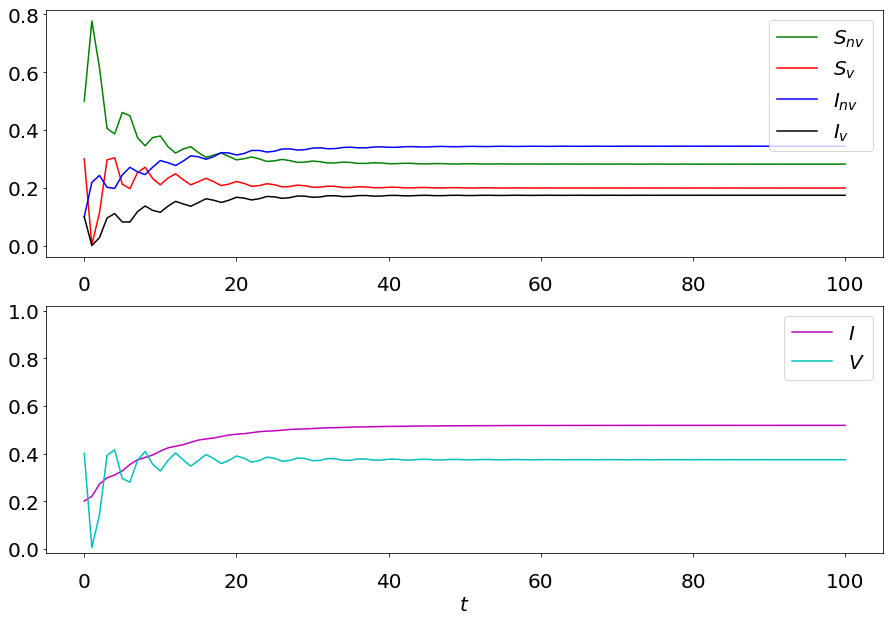

In [1899]:
fig, (ax, ax2) = plt.subplots(ncols=1,nrows=2,figsize=(15,10))

ax.plot(time,Snv,label="$S_{nv}$",c="g")
ax.plot(time,Sv,label="$S_v$",c="r")
ax.plot(time,Inv,label="$I_{nv}$",c="b")
ax.plot(time,Iv,label="$I_v$",c="k")
ax.tick_params(labelsize=20)
ax.tick_params(axis='x', pad=15)
#ax.set_xlabel("$t$",fontsize=20)
ax.legend(fontsize=20)

print(np.mean(Iv[int(len(Sv)/2):])+np.mean(Inv[int(len(Sv)/2):]))
print(np.mean(Sv[int(len(Sv)/2):])+np.mean(Iv[int(len(Sv)/2):]))
print(max(Infected[int(len(Infected)/2):])-np.mean(Infected[int(len(Infected)/2):]))
ax2.plot(time,Infected,label="$I$",c="m")
ax2.plot(time,Vaccinated,label="$V$",c="c")
ax2.legend()
ax2.tick_params(labelsize=20)
ax2.tick_params(axis='x', pad=15)
ax2.set_xlabel("$t$",fontsize=20)
ax2.legend(fontsize=20)
ax2.set_ylim([-0.02,1.02])
#plt.savefig("Latex/LimitCycle.pdf",bbox_inches='tight')
plt.show()

In [1208]:
beta = 2*(T+c)
time,Snv,Sv,Inv,Iv,Infected1,Vaccinated1 = numericalSolution(y0,t,c,lamda,T,mu,gamma,k,beta)
beta = 5*(T+c)
time,Snv,Sv,Inv,Iv,Infected2,Vaccinated2 = numericalSolution(y0,t,c,lamda,T,mu,gamma,k,beta)

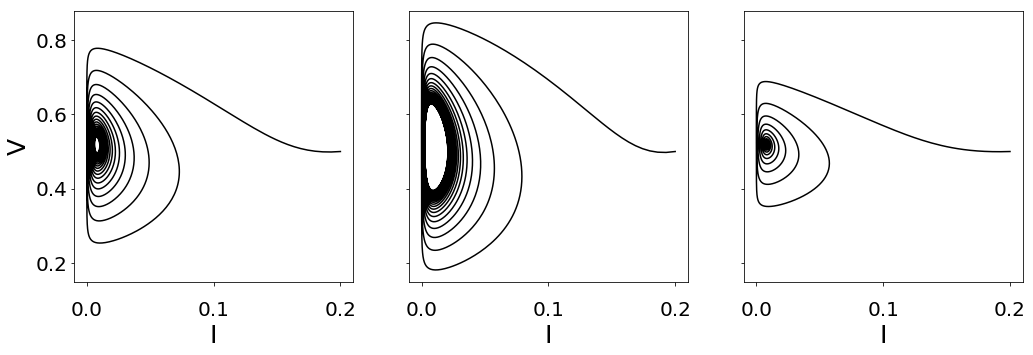

In [1209]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(17,5))
ax[0].plot(Infected1,Vaccinated1,c="k")
ax[0].tick_params(labelsize=20)
ax[0].tick_params(axis='x', pad=15)
ax[0].set_ylabel("V",fontsize=25)
ax[0].set_xlabel("I",fontsize=25)

ax[1].plot(Infected,Vaccinated,c="k")
ax[1].tick_params(labelsize=20)
ax[1].tick_params(axis='x', pad=15)
ax[1].set_xlabel("I",fontsize=25)

ax[2].plot(Infected2,Vaccinated2,c="k")
ax[2].tick_params(labelsize=20)
ax[2].tick_params(axis='x', pad=15)
ax[2].set_xlabel("I",fontsize=25)

plt.savefig("Latex/SelectionPressure.pdf",bbox_inches='tight')

# Periodic solution

<IPython.core.display.Javascript object>


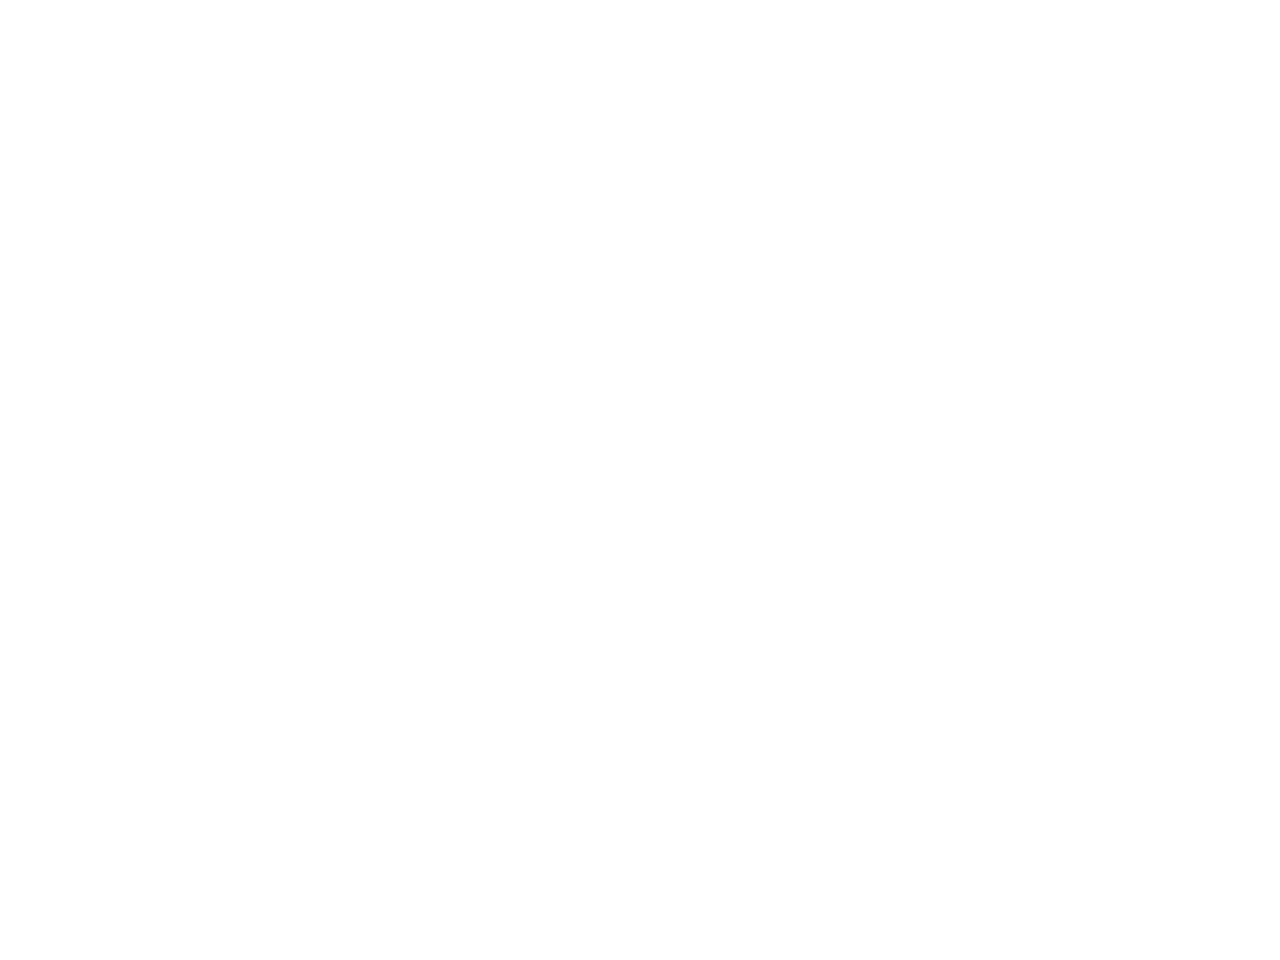

ValueError: Unknown projection '3d'

In [70]:
%matplotlib notebook
ax = plt.axes(projection='3d')
ax.plot3D(vh, nh, nI,c="k")
ax.set_xlabel("$v_{h}$")
ax.set_ylabel("$n_{h}$")
ax.set_zlabel("$n_{I}$")
plt.show()

%matplotlib inline

In [77]:
%matplotlib inline

In [71]:
def getResultsLamdaGamma(T,beta,mu,k,c,gamma):
    gamma = np.linspace(0,1,50)
    lamda = np.linspace(0,1,50)
    I = np.zeros([len(gamma),len(gamma)])
    V = np.zeros([len(gamma),len(gamma)])
    t = 1000
    y0 = [0.25, 0.25,0.25,0.25]
    
    for i in range(0,len(gamma)):
        for j in range(0,len(gamma)):
            time,Snv,Sv,Inv,Iv,Infected,Vaccinated = numericalSolution(y0,t,c,lamda[len(lamda)-i-1],T,mu,gamma[j],k,beta)
            I[i,j] = np.mean(Infected[int(len(Infected)/2):])
            V[i,j] = np.mean(Vaccinated[int(len(Infected)/2):])
        
    return lamda,beta,I,V

In [1147]:
def getResultsGamma(T,beta,mu,k,c,lamda):
    gamma = np.linspace(0,1,100)
    I = np.zeros(len(gamma))
    V = np.zeros(len(gamma))
    t = 10000
    y0 = [0.25, 0.25,0.25,0.25]
    
    for i in range(0,len(gamma)):
        time,Snv,Sv,Inv,Iv,Infected,Vaccinated = numericalSolution(y0,t,c,lamda,T,mu,gamma[i],k,beta)
        I[i] = np.mean(Infected[int(len(Infected)/2):])
        V[i] = np.mean(Vaccinated[int(len(Infected)/2):])
        
    return gamma,I,V

In [1278]:
def getAmplitudesLamdaGamma(T,beta,mu,k,c,gamma):
    gamma = np.linspace(0,1,50)
    lamda = np.linspace(0,1,50)
    IA = np.zeros([len(gamma),len(gamma)])
    VA = np.zeros([len(gamma),len(gamma)])
    t = 5000
    y0 = [0.25, 0.25,0.25,0.25]
    
    for i in range(0,len(lamda)):
        for j in range(0,len(gamma)):
            time,Snv,Sv,Inv,Iv,Infected,Vaccinated = numericalSolution(y0,t,c,lamda[len(lamda)-i-1],T,mu,gamma[j],k,beta)
            IA[i,j] = max(Infected[int(len(Infected)/2):])-np.mean(Infected[int(len(Infected)/2):])
            VA[i,j] = max(Vaccinated[int(len(Infected)/2):])-np.mean(Vaccinated[int(len(Infected)/2):])
        
    return lamda,beta,IA,VA

In [1805]:
T = 10
c = 1
beta = T+c
mu = 0.1
k = 1
gamma = 0.3

In [1283]:
lamda,beta,IA,VA = getAmplitudesLamdaGamma(T,beta,mu,k,c,gamma)

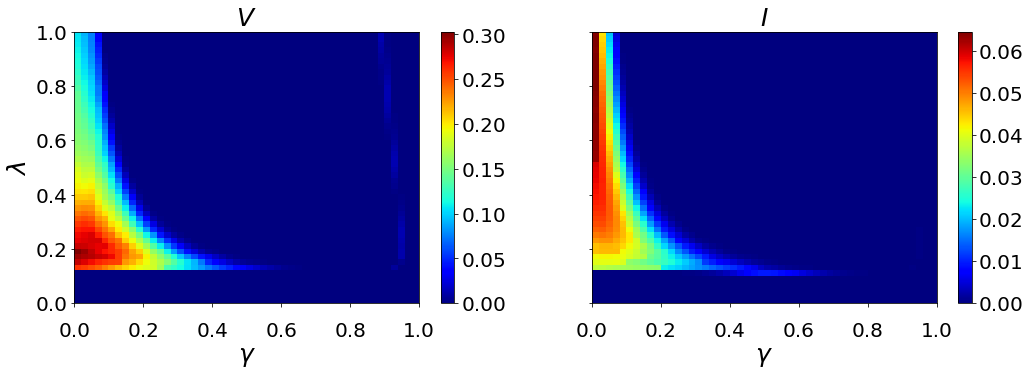

In [1285]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(17,5))

im = ax[0].imshow(VA,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
ax[0].set_xlabel("$\gamma$",fontsize=25)
ax[0].set_ylabel("$\lambda$",fontsize=25)
ax[0].tick_params(labelsize=20)
ax[0].set_title("$V$",fontsize=25)
ax[0].tick_params(axis='x', pad=15)

im = ax[1].imshow(IA,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
ax[1].set_xlabel("$\gamma$",fontsize=25)
ax[1].tick_params(labelsize=20)
ax[1].set_title("$I$",fontsize=25)
ax[1].tick_params(axis='x', pad=15)

In [1806]:
T=10
beta = T+c
beta = 10
lamda,beta,I,V = getResultsLamdaGamma(T,beta,mu,k,c,gamma)
#lamda,beta,IA,VA = getAmplitudesLamdaGamma(T,beta,mu,k,c,gamma)
T = 20
#beta = T+c
lamda,beta,I1,V1 = getResultsLamdaGamma(T,beta,mu,k,c,gamma)
#lamda,beta,IA1,VA1 = getAmplitudesLamdaGamma(T,beta,mu,k,c,gamma)
T = 30
#beta = T+c
lamda,beta,I2,V2 = getResultsLamdaGamma(T,beta,mu,k,c,gamma)
#lamda,beta,IA2,VA2 = getAmplitudesLamdaGamma(T,beta,mu,k,c,gamma)

In [1807]:
#lamda,beta,IA,VA = getAmplitudesLamdaGamma(T,beta,mu,k,c,gamma)

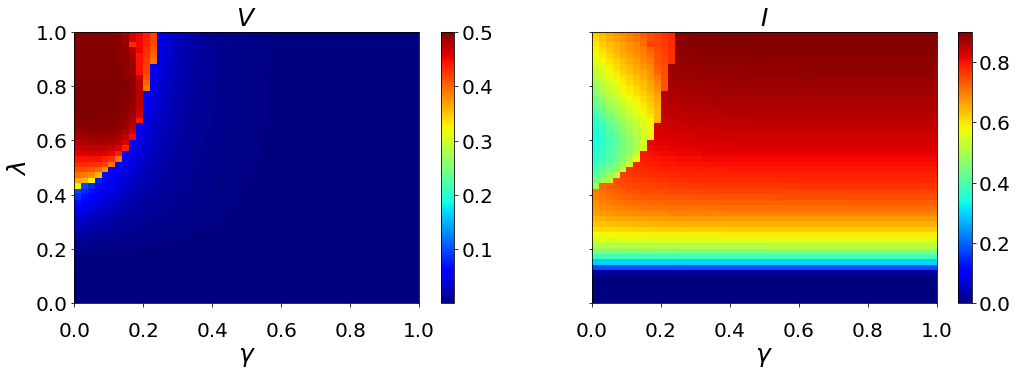

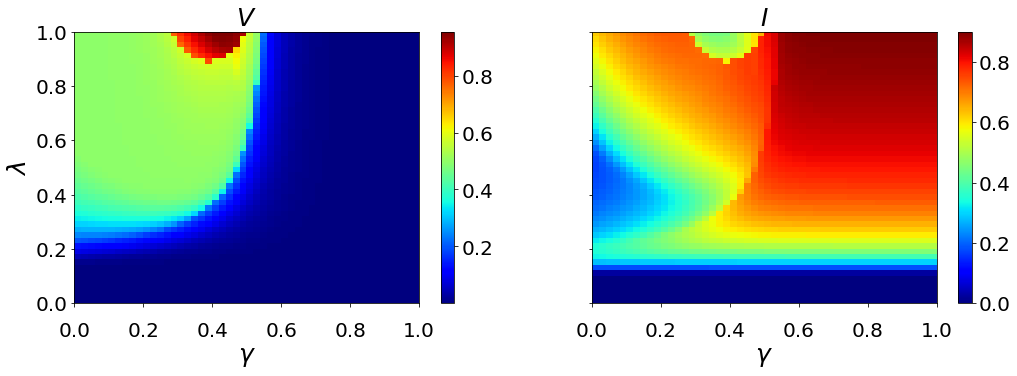

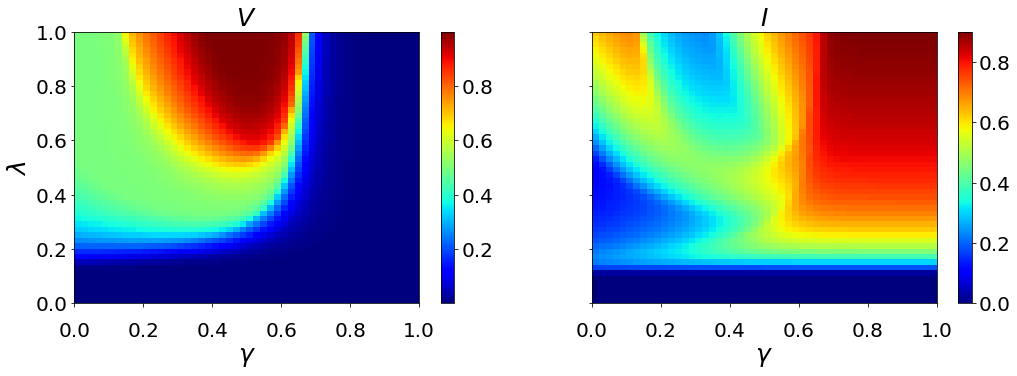

In [1808]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(17,5))

im = ax[0].imshow(V,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
ax[0].set_xlabel("$\gamma$",fontsize=25)
ax[0].set_ylabel("$\lambda$",fontsize=25)
ax[0].tick_params(labelsize=20)
ax[0].set_title("$V$",fontsize=25)
ax[0].tick_params(axis='x', pad=15)

im = ax[1].imshow(I,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
ax[1].set_xlabel("$\gamma$",fontsize=25)
ax[1].tick_params(labelsize=20)
ax[1].set_title("$I$",fontsize=25)
ax[1].tick_params(axis='x', pad=15)

"""
im = ax[2].imshow(VA,extent=[min(beta),max(beta),0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[2])
cbar.ax.tick_params(labelsize=20)
ax[2].tick_params(axis='x', pad=15)
ax[2].tick_params(labelsize=20)
ax[2].set_title("$A(V)$",fontsize=25)
ax[2].set_xlabel("$M$",fontsize=25)

im = ax[3].imshow(IA,extent=[min(beta),max(beta),0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[3])
cbar.ax.tick_params(labelsize=20)
ax[3].tick_params(axis='x', pad=15)
ax[3].tick_params(labelsize=20)
ax[3].set_title("$A(I)$",fontsize=25)
ax[3].set_xlabel("$M$",fontsize=25)
"""

#plt.savefig("Latex/HeatMap.pdf",bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(17,5))

im = ax[0].imshow(V1,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
ax[0].set_xlabel("$\gamma$",fontsize=25)
ax[0].set_ylabel("$\lambda$",fontsize=25)
ax[0].tick_params(labelsize=20)
ax[0].set_title("$V$",fontsize=25)
ax[0].tick_params(axis='x', pad=15)

im = ax[1].imshow(I1,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
ax[1].set_xlabel("$\gamma$",fontsize=25)
ax[1].tick_params(labelsize=20)
ax[1].set_title("$I$",fontsize=25)
ax[1].tick_params(axis='x', pad=15)

plt.show()

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(17,5))

im = ax[0].imshow(V2,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
ax[0].set_xlabel("$\gamma$",fontsize=25)
ax[0].set_ylabel("$\lambda$",fontsize=25)
ax[0].tick_params(labelsize=20)
ax[0].set_title("$V$",fontsize=25)
ax[0].tick_params(axis='x', pad=15)

im = ax[1].imshow(I2,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
ax[1].set_xlabel("$\gamma$",fontsize=25)
ax[1].tick_params(labelsize=20)
ax[1].set_title("$I$",fontsize=25)
ax[1].tick_params(axis='x', pad=15)

plt.show()

In [1770]:
T = 5
c = 0.1
beta = T+c
mu = 0.1
k = 1
gamma = 0.3
lamda = 0.5

In [1771]:
gamma,I,V = getResultsGamma(T,beta,mu,k,c,lamda)

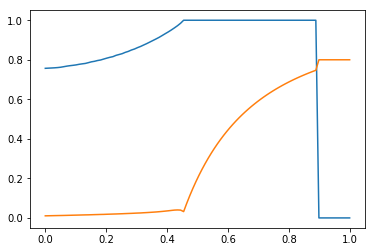

In [1772]:
plt.plot()
plt.plot(gamma,V)
plt.plot(gamma,I)
plt.show()

# Network

In [3]:
class systemOfAgents:
    def __init__(self,lamda,c,T,N,fV,fI,mu,gamma,GE,GG,M,alpha):
        self.lamda = lamda
        self.c = c
        self.T = T
        self.N = N
        self.V = [int(rd.random() < fV) for i in range(0,N)]
        self.Inf = [0 for i in range(0,N)]
        self.Win = np.zeros(self.N)
        self.fI = fI
        self.mu = mu
        self.gamma = gamma
        self.GE = GE
        self.GG = GG
        self.M = M
        self.countI = 0
        self.alpha = alpha
        self.countIv = 0
    
    def updatePayoff(self):
        l = 0
        n = 0
        self.countIv = 0
        for i in range(0,self.N):
            if self.Inf[i] == 1 and self.V[i] == 1:
                self.countIv += 1
                
        for i in range(0,self.N):
            n = list(self.GG.neighbors(i))
            l = len(n)
            if l != 0:
                if self.V[i] == 1:
                    self.Win[i] += -c
                    for ne in n:
                        self.Win[i] += -T*self.Inf[ne]*self.gamma/l*(1-alpha)
                    self.Win[i] += -T*self.countI/self.N*alpha*self.gamma
                else:
                    for ne in n:
                        self.Win[i] += (-T*self.Inf[ne]*self.gamma/l*self.V[ne]-T*self.Inf[ne]/l*(1-self.V[ne]))*(1-alpha)
                    self.Win[i] += (-T*self.gamma*self.countIv/self.N-T*(self.countI-self.countIv)/self.N)*alpha
                    #print((self.countI-self.countIv))
        
        self.updateStrategies()
        self.Win = np.zeros(self.N)
            
    def updateStrategies(self):
        neighbours = 0
        m = 0
        NewStrategies = [s for s in self.V]
        for i in range(0,self.N):
            neighbours = list(self.GG.neighbors(i))
            if neighbours != []:
                m = neighbours[rd.randint(0,len(neighbours)-1)]
                #if rd.random() <= (self.Win[m]-self.Win[i])/self.M and (self.Win[m]-self.Win[i]) > 0:
                if rd.random() <= 1.0/(1+np.exp(-self.M*(self.Win[m]-self.Win[i]))):
                        NewStrategies[i] = self.V[m]
        self.V = NewStrategies
        
    def initializeInfections(self):
        for i in range(0,self.N):
            if self.V[i] == 1:
                if rd.random() < self.gamma:
                    self.V[0] = 0
                    self.countIv += 1
            if self.V[i] == 0:
                if rd.random() < self.fI:
                    self.Inf[i] = 1
                    self.countI += 1

                    
    def update(self):
        self.updatePayoff()
        self.updateStrategies()
                    
    def updateHealth(self):
        NewHealth = [s for s in self.Inf]
        
        for edges in self.GE.edges():
            if self.Inf[edges[0]] == 1 and self.Inf[edges[1]] == 0 and NewHealth[edges[1]] == 0:
                if self.V[edges[1]] == 0 and self.V[edges[0]] == 0:
                    if rd.random() < self.lamda:
                        NewHealth[edges[1]] = 1
                        self.countI += 1
                else:
                    if rd.random() < self.lamda*self.gamma:
                        NewHealth[edges[1]] = 1
                        self.countI += 1
                        if self.V[edges[1]] == 1:
                            self.countIv += 1
            if self.Inf[edges[0]] == 0 and NewHealth[edges[0]] == 0 and self.Inf[edges[1]] == 1:
                if self.V[edges[0]] == 0 and self.V[edges[1]] == 0:
                    if rd.random() < self.lamda:
                        NewHealth[edges[0]] = 1
                        self.countI += 1
                else:
                    if rd.random() < self.lamda*self.gamma:
                        NewHealth[edges[0]] = 1
                        self.countI += 1
                        if self.V[edges[0]] == 1:
                            self.countIv += 1

        for i in range(0,self.N):
            if NewHealth[i] == 1:
                if rd.random() < self.mu:
                    NewHealth[i] = 0
                    self.countI += -1
                    if self.V[i] == 1:
                        self.countIv += -1
                    
        self.Inf = [s for s in NewHealth]
   
        
    
    def getV(self):
        return float(np.sum(self.V))/self.N
    
    def getI(self):
        return float(self.countI)/self.N

In [4]:
class simulateSystemOfAgents:
    def __init__(self,simulationStepsGame,lamda,c,T,N,fV,fI,mu,gamma,GG,GE,Beta,alpha):
        self.simulationStepsGame = simulationStepsGame
        self.SystemOfAgents = systemOfAgents(lamda,c,T,N,fV,fI,mu,gamma,GG,GE,Beta,alpha)
        self.V = [self.SystemOfAgents.getV()]
        self.Inf = []
        
    def simulate(self):
        self.SystemOfAgents.initializeInfections()
        self.Inf.append(self.SystemOfAgents.getI())
        for i in range(0,self.simulationStepsGame):
            self.SystemOfAgents.update()
            self.V.append(self.SystemOfAgents.getV())
            self.SystemOfAgents.updateHealth()
            self.Inf.append(self.SystemOfAgents.getI())
            
    def printResult(self,s):
        V = []
        I = []
        
        for i in range(s,len(self.V)-1-s):
            V.append(np.mean(self.V[i-s:i+s]))
            I.append(np.mean(self.Inf[i-s:i+s]))
        
        plt.figure(figsize=(8, 6), dpi=80)
        plt.plot(V ,color="b",ls="--",label="V")
        plt.xlabel("$Step$",fontsize=15)
        plt.ylabel("$V$",fontsize=15)
        plt.legend(fontsize=20)
        plt.show()
        
        plt.figure(figsize=(8, 6), dpi=80)
        plt.plot(I ,color="r",ls="--",label="I")
        plt.xlabel("$Step$",fontsize=15)
        plt.ylabel("$I$",fontsize=15)
        plt.legend(fontsize=20)
        plt.show()
        
        print(np.mean(self.V[int(len(self.V)/2):]))
        print(np.mean(self.Inf[int(len(self.V)/2):]))


    def getV(self):
        return np.mean(self.V[int(len(self.V)/2):])
    
    def getI(self):
        return np.mean(self.Inf[int(len(self.Inf)/2):])
    
    def getI0(self):
        return self.Inf[0]

In [374]:
def getNegativeCorrelated(G1,G2):
    k1 = list(G1.degree())
    k2 = list(G2.degree())

    edges1 = G1.edges()
    edges2 = G2.edges()

    shuffle1 = rd.sample(list(range(0,N)),N)
    shuffle2 = rd.sample(list(range(0,N)),N)

    #k1, shuffle1 = zip(*sorted(zip(k1, shuffle1)))
    #k2, shuffle2 = zip(*sorted(zip(k2, shuffle2),reverse=True))

    G1 = nx.Graph()
    G1.add_nodes_from(range(0,N))
    for e in edges1:
        G1.add_edge(shuffle1[e[0]],shuffle1[e[1]])

    G2 = nx.Graph()
    G2.add_nodes_from(range(0,N))
    for e in edges2:
        G2.add_edge(shuffle2[e[0]],shuffle2[e[1]])
        
    return G1,G2

In [173]:
def getVaccinatedInfected(simulationStepsGame,lamda,c,T,N,fV,fI,mu,gamma,G1,G2,Beta,alpha):
    t = simulateSystemOfAgents(simulationStepsGame,lamda,c,T,N,fV,fI,mu,gamma,G1,G2,Beta,alpha)
    t.simulate()

    return t.getI(),t.getV()

In [6557]:
N = 500

fV = 0.0
T = 1
c = 0.1
mu = 0.1
fI = 0.1
gamma = 0.2
lamda = 0.07
Beta = 10
alpha = 0.0

simulationStepsGame = 1000

G1 = nx.barabasi_albert_graph(N,2)
G2 = nx.barabasi_albert_graph(N,2)

#G1,G2 = getNegativeCorrelated(G1,G2)
#
#S = simulateSystemOfAgents(simulationStepsGame,lamda,c,T,N,fV,fI,mu,gamma,G1,G2,Beta,alpha)
#S.simulate()



In [6558]:
#S.printResult(1)
print(getVaccinatedInfected(simulationStepsGame,lamda,c,T,N,fV,fI,mu,gamma,G1,G2,Beta,alpha))

(0.51876247504990014, 0.0)


In [7]:
def getResultsLamdaGammaNetwork(simulationStepsGame,c,T,N,fV,fI,mu,G1,G2,Beta,alpha):
    gamma = np.linspace(0.0,1,20)
    lamda = np.linspace(0.0,1,20)
    I = np.zeros([len(lamda),len(gamma)])
    V = np.zeros([len(lamda),len(gamma)])

    for i in range(0,len(lamda)):
        print(i)
        for j in range(0,len(gamma)):
            a,b = getVaccinatedInfected(simulationStepsGame,lamda[len(lamda)-1-i],c,T,N,fV,fI,mu,gamma[j],G1,G2,Beta,alpha)
            V[i,j] = b
            I[i,j] = a
            
    return lamda,beta,I,V

In [8]:
N = 500

fV = 0.3
T = 1
c = 0.1
mu = 0.1
fI = 0.1

Beta = 10
alpha = 0.0
gamma = 0.2
lamda = 0.1

simulationStepsGame = 500

G1 = nx.barabasi_albert_graph(N,2)
G2 = nx.barabasi_albert_graph(N,2)

In [6535]:
lamda,gamma,INet,VNet = getResultsLamdaGammaNetwork(simulationStepsGame,c,T,N,fV,fI,mu,G1,G2,Beta,alpha)

0


KeyboardInterrupt: 

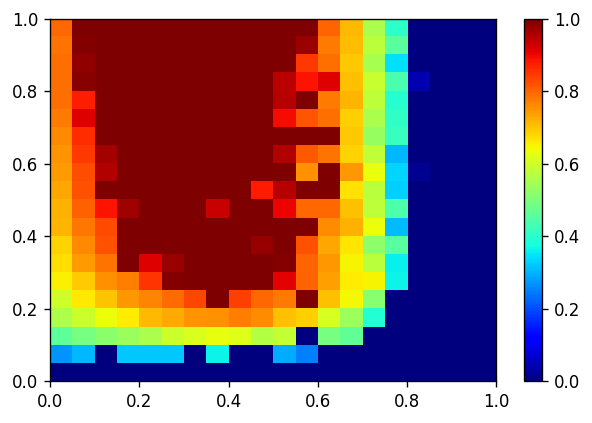

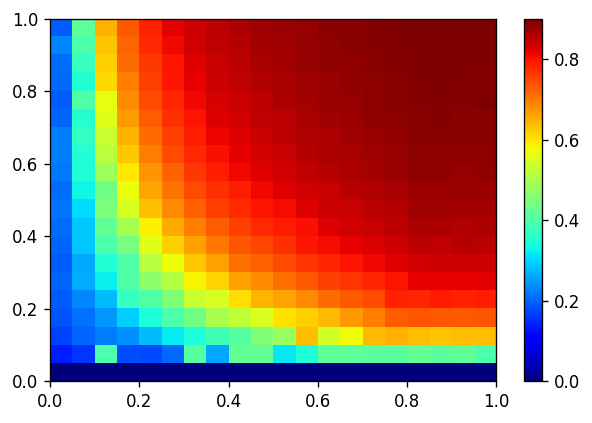

In [6344]:
plt.figure(dpi=120)
plt.imshow(VNet,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.show()

plt.figure(dpi=120)
plt.imshow(INet,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.show()

0.9
0.2
0.1
0.0
0.1
1
(0.7745896414342629, 0.0)


In [322]:
def writeParameters(fV,T,c,mu,fI,gamma,lamda,Beta,alpha):
    listParameters = [fV,T,c,mu,fI,gamma,lamda,Beta,alpha]
    file = open("Parameters.txt","w")

    for i in range(0,len(listParameters)):
        file.write(str(listParameters[i]))
        file.write(" ")
    file.close()
        
def writeNetwork(GE,GG,N):
    file = open("EdgesE.txt","w")

    file.write(str(len(GE.edges())))
    file.write(" ")

    for edges in GE.edges():
        file.write(str(edges[0]))
        file.write(" ")
        file.write(str(edges[1]))
        file.write(" ")

    file.close()
    
    file = open("EdgesG.txt","w")

    file.write(str(len(GG.edges())))
    file.write(" ")

    for edges in GG.edges():

        file.write(str(edges[0]))
        file.write(" ")
        file.write(str(edges[1]))
        file.write(" ")
    
    file.close()
    
    file = open("NeighborsG.txt","w")

    for i in range(0,N):
        l = list(GG.neighbors(i))
        if l != []:
             for j in range(0,len(l)):
                file.write(str(l[j]+1))
                file.write(" ")
        else: 
            file.write("0")
            file.write(" ")
        file.write("\n")

    file.close()

def executeCPlus():
    os.system("./oneOne")

def readOutput():
    file = open('output.txt', 'r')
    string = file.read()
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", string)
    file.close()
    return float(numbers[0]),float(numbers[1])

In [323]:
def runCPLus(fV,T,c,mu,fI,gamma,lamda,Beta,alpha):
    writeParameters(fV,T,c,mu,fI,gamma,lamda,Beta,alpha)
    executeCPlus()
    V,I = readOutput()
    return V,I

In [332]:
N = 1000

fV = 0.3
T = 1
c = 0.1
mu = 0.1
fI = 0.5

Beta = 10
alpha = 0.0
gamma = 0.0
lamda = 0.931034482759

simulationStepsGame = 500

G1 = nx.barabasi_albert_graph(N,2)
G2 = nx.barabasi_albert_graph(N,2)

writeNetwork(G1,G2,N)
print(runCPLus(fV,T,c,mu,fI,gamma,lamda,Beta,alpha))

(0.789896, 0.20212)


In [379]:
def getResultsLamdaGammaNetworkC(simulationStepsGame,NIter,c,T,N,fV,fI,mu,Beta,alpha,corr):
    gamma = np.linspace(0.0,1,50)
    lamda = np.linspace(0.0,1,50)
    I = np.zeros([len(lamda),len(gamma)])
    V = np.zeros([len(lamda),len(gamma)])
    
    for k in range(0,NIter):
        print(k)
        if corr == 1:
            G1 = nx.barabasi_albert_graph(N,2)
            writeNetwork(G1,G1,N)
        else:
            G1 = nx.barabasi_albert_graph(N,2)
            G2 = nx.barabasi_albert_graph(N,2)
            G1,G2 = getNegativeCorrelated(G1,G2)
            writeNetwork(G1,G2,N)
        for i in range(0,len(lamda)):
            #print(i)
            for j in range(0,len(gamma)):
                a,b = runCPLus(fV,T,c,mu,fI,gamma[j],lamda[len(lamda)-1-i],Beta,alpha)
                V[i,j] += a/NIter
                I[i,j] += b/NIter
                if a > 1 or b > 1:
                    print("gamma")
                    print(gamma[j])
                    print("lamda")
                    print(lamda[len(lamda)-1-i])
                    print("V")
                    print(a)
                    print("I")
                    print(b)
                    print
                    sys.exit("Error message")
    return lamda,gamma,I,V

In [380]:
N = 1000

fV = 0.3
T = 1
c = 0.1
mu = 0.1
fI = 0.1

Beta = 10
alpha = 0.0
gamma = 0.2
lamda = 0.1
NIter = 5

simulationStepsGame = 500

G1 = nx.barabasi_albert_graph(N,2)

In [381]:
lamda,gamma,INet,VNet = getResultsLamdaGammaNetworkC(simulationStepsGame,NIter,c,T,N,fV,fI,mu,Beta,alpha,1)

0
1
2
3
4


In [382]:
alpha = 1
lamda,gamma,INetGlob,VNetGlob = getResultsLamdaGammaNetworkC(simulationStepsGame,NIter,c,T,N,fV,fI,mu,Beta,alpha,1)

0
1
2
3
4


In [383]:
alpha = 0.0
lamda,gamma,INetDec,VNetDec = getResultsLamdaGammaNetworkC(simulationStepsGame,NIter,c,T,N,fV,fI,mu,Beta,alpha,0)

0
1
2
3
4


In [384]:
alpha = 1.0
lamda,gamma,INetGlobDec,VNetGlobDec = getResultsLamdaGammaNetworkC(simulationStepsGame,NIter,c,T,N,fV,fI,mu,Beta,alpha,0)

0
1
2
3
4


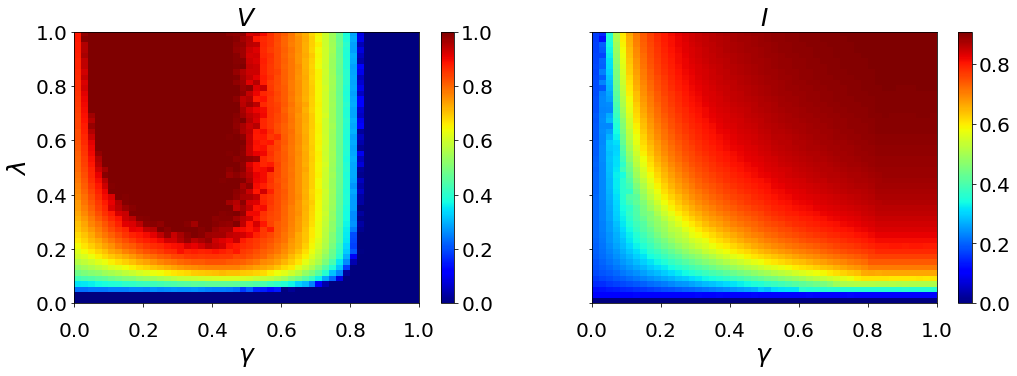

In [385]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(17,5))

im = ax[0].imshow(VNet,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
ax[0].set_xlabel("$\gamma$",fontsize=25)
ax[0].set_ylabel("$\lambda$",fontsize=25)
ax[0].tick_params(labelsize=20)
ax[0].set_title("$V$",fontsize=25)
ax[0].tick_params(axis='x', pad=15)

im = ax[1].imshow(INet,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
ax[1].set_xlabel("$\gamma$",fontsize=25)
ax[1].tick_params(labelsize=20)
ax[1].set_title("$I$",fontsize=25)
ax[1].tick_params(axis='x', pad=15)

plt.show()

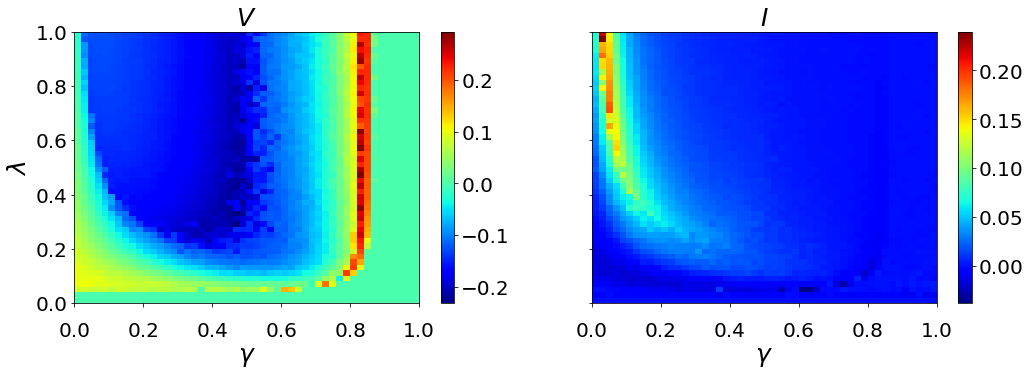

In [386]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(17,5))

im = ax[0].imshow(VNetGlob-VNet,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
ax[0].set_xlabel("$\gamma$",fontsize=25)
ax[0].set_ylabel("$\lambda$",fontsize=25)
ax[0].tick_params(labelsize=20)
ax[0].set_title("$V$",fontsize=25)
ax[0].tick_params(axis='x', pad=15)

im = ax[1].imshow(INetGlob-INet,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
ax[1].set_xlabel("$\gamma$",fontsize=25)
ax[1].tick_params(labelsize=20)
ax[1].set_title("$I$",fontsize=25)
ax[1].tick_params(axis='x', pad=15)

plt.show()

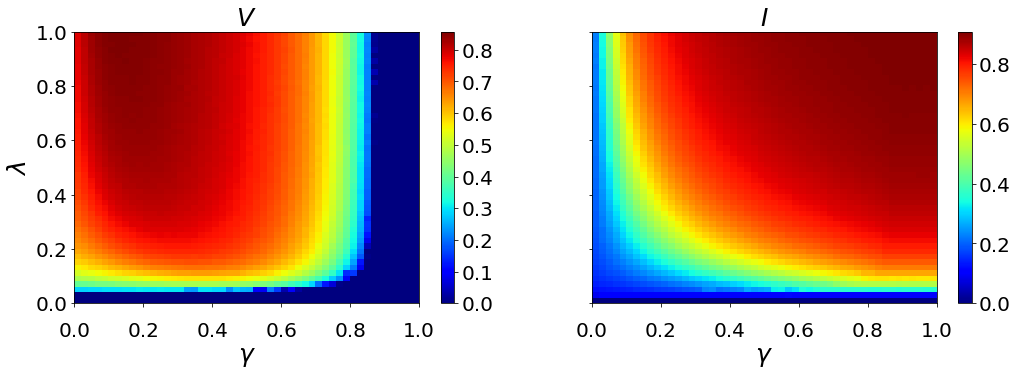

In [387]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(17,5))

im = ax[0].imshow(VNetGlobDec,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
ax[0].set_xlabel("$\gamma$",fontsize=25)
ax[0].set_ylabel("$\lambda$",fontsize=25)
ax[0].tick_params(labelsize=20)
ax[0].set_title("$V$",fontsize=25)
ax[0].tick_params(axis='x', pad=15)

im = ax[1].imshow(INetGlobDec,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
ax[1].set_xlabel("$\gamma$",fontsize=25)
ax[1].tick_params(labelsize=20)
ax[1].set_title("$I$",fontsize=25)
ax[1].tick_params(axis='x', pad=15)

plt.show()

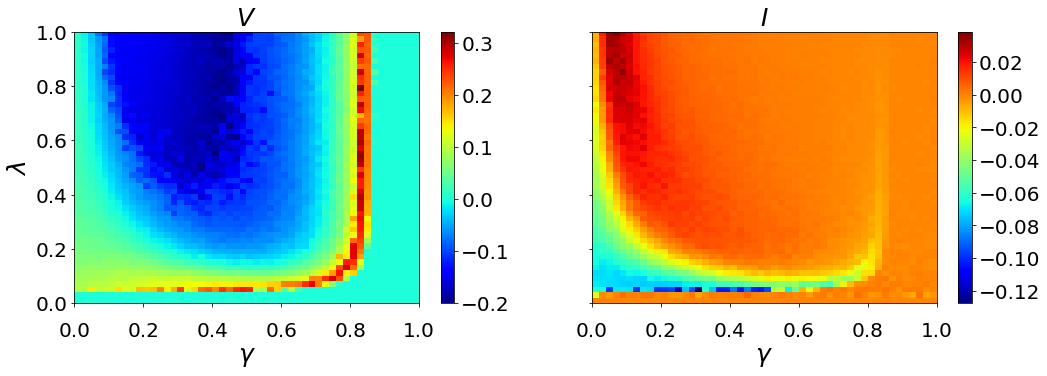

In [388]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(17,5))

im = ax[0].imshow(VNetGlobDec-VNetDec,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
ax[0].set_xlabel("$\gamma$",fontsize=25)
ax[0].set_ylabel("$\lambda$",fontsize=25)
ax[0].tick_params(labelsize=20)
ax[0].set_title("$V$",fontsize=25)
ax[0].tick_params(axis='x', pad=15)

im = ax[1].imshow(INetGlobDec-INetDec,extent=[0,1,0,1],aspect='auto',cmap=plt.get_cmap("jet"))
cbar = fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
ax[1].set_xlabel("$\gamma$",fontsize=25)
ax[1].tick_params(labelsize=20)
ax[1].set_title("$I$",fontsize=25)
ax[1].tick_params(axis='x', pad=15)

plt.show()

In [401]:
def getResultsLamdaNetworkC(simulationStepsGame,NIter,c,T,N,fV,fI,mu,gamma,Beta,alpha,corr):
    lamda = np.linspace(0.0,1,30)
    I = np.zeros(len(lamda))
    V = np.zeros(len(lamda))
    
    for k in range(0,NIter):
        print(k)
        if corr == 1:
            G1 = nx.barabasi_albert_graph(N,2)
            writeNetwork(G1,G1,N)
        else:
            G1 = nx.barabasi_albert_graph(N,2)
            G2 = nx.barabasi_albert_graph(N,2)
            G1,G2 = getNegativeCorrelated(G1,G2)
            writeNetwork(G1,G2,N)
        for i in range(0,len(lamda)):
            #print(i)
            a,b = runCPLus(fV,T,c,mu,fI,gamma,lamda[i],Beta,alpha)
            V[i] += a/NIter
            I[i] += b/NIter
    return lamda,I,V

In [414]:
N = 5000

fV = 0.3
T = 1
c = 0.1
mu = 0.1
fI = 0.1

Beta = 10
alpha = 0.0
gamma = 0.3
lamda = 0.1
NIter = 5

In [415]:
alpha=0.0
lamda,ILamdaLoc,VLamdaLoc = getResultsLamdaNetworkC(simulationStepsGame,NIter,c,T,N,fV,fI,mu,gamma,Beta,alpha,1)
alpha = 1.0
lamda,ILamdaGlob,VLamdaGlob = getResultsLamdaNetworkC(simulationStepsGame,NIter,c,T,N,fV,fI,mu,gamma,Beta,alpha,1)

0
1
2
3
4
0
1
2
3
4


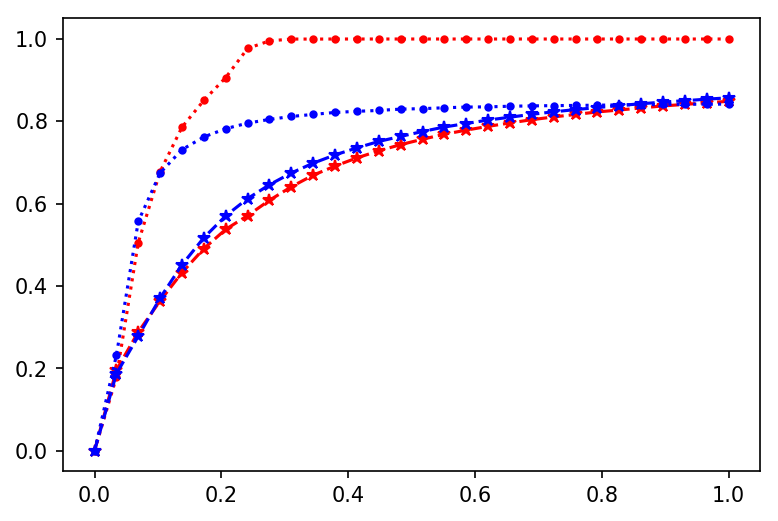

In [411]:
plt.figure(dpi=150)
plt.plot(lamda,ILamdaLoc,c="r",ls="--",marker="*")
plt.plot(lamda,VLamdaLoc,c="r",ls=":",marker=".")
plt.plot(lamda,ILamdaGlob,c="b",ls="--",marker="*")
plt.plot(lamda,VLamdaGlob,c="b",ls=":",marker=".")
plt.show()

In [412]:
alpha=0.0
lamda,ILamdaLocDec,VLamdaLocDec = getResultsLamdaNetworkC(simulationStepsGame,NIter,c,T,N,fV,fI,mu,gamma,Beta,alpha,0)
alpha = 1.0
lamda,ILamdaGlobDec,VLamdaGlobDec = getResultsLamdaNetworkC(simulationStepsGame,NIter,c,T,N,fV,fI,mu,gamma,Beta,alpha,0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


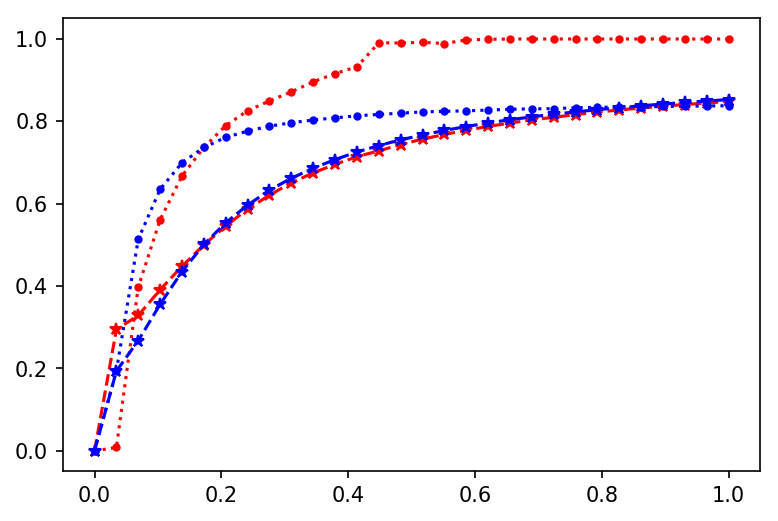

In [413]:
plt.figure(dpi=150)
plt.plot(lamda,ILamdaLocDec,c="r",ls="--",marker="*")
plt.plot(lamda,VLamdaLocDec,c="r",ls=":",marker=".")
plt.plot(lamda,ILamdaGlobDec,c="b",ls="--",marker="*")
plt.plot(lamda,VLamdaGlobDec,c="b",ls=":",marker=".")
plt.show()